# Angle of Arrival (AoA)

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Angle_of_Arrival.ipynb)

Below is an intro to mmWrt for simple Angle of Arrival (AoA) estimation

## Setup

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt
print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
2024-10-01 19:51:28.451436


In [2]:
from os.path import abspath, join, pardir
import sys
from numpy.fft import fft, fftshift
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from numpy import arange, cos, sin, pi, zeros

from mmWrt.Scene import Antenna, Medium, Radar, Receiver, Target, Transmitter
from mmWrt.Raytracing import rt_points
from mmWrt import __version__
print(__version__)

0.0.7


## Example

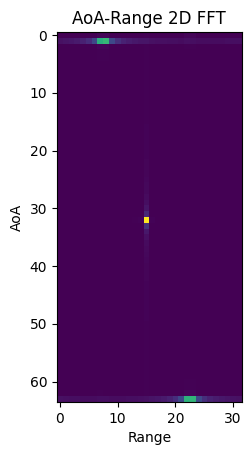

In [21]:
f0 = 62e9
# Number of ADC samples
NA = 64
# Number of RX channels
NR = 64

void = Medium()
c = void.v
lambda0 = c/f0
_fs = 4e3
_k = 70e8
RXs = [Antenna(x=lambda0/2*i) for i in range(NR)]
radar = Radar(transmitter=Transmitter(bw=3.5e9, slope=_k),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=False)
r1, theta1 = 10.1, 0
x1, y1 = r1*cos(theta1), r1*sin(theta1)
r2, theta2 = 20.1, pi/2
x2, y2 = r2*cos(theta2), r2*sin(theta2)
r3, theta3 = 30.1, pi
x3, y3 = r3*cos(theta3), r3*sin(theta3)

target1 = Target(x1, y1, 0)  # 0 degrees on x-axis <=> -pi/2 vs bore sight
target2 = Target(x2, y2, 0) # pi/2 degrees vs x-ax <=> 0 degree vs bore sight
target3 = Target(x3, y3, 0) # 180 degrees on x-axis <=> pi/2 vs boresight
targets = [target1, target2, target3]

bb = rt_points(radar, targets,
               debug=False)
cube = bb["adc_cube"]
# first compute the range FFT
R_fft = fft(cube, axis=4)
# then compute the AoA FFT
A_FFT = fft(R_fft, axis=3)
# for Range vs AoA, display magnitude
# and need to fftshift to have the negative frequencies moved around 0
Z_fft = abs(fftshift(A_FFT[0,0,0,:,:], axes=0))
plt.xlabel("Range")
plt.ylabel("AoA")
plt.title('AoA-Range 2D FFT')
plt.imshow(Z_fft[:,:NA//2])

### adding legends

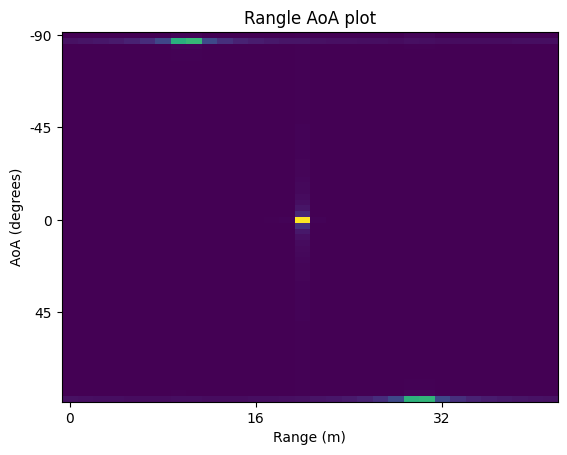

In [22]:
ranges = arange(0, _fs*c/2/_k, _fs*c/2/_k/NA)
angles = arange(-90, 90, 180/NR)

no_labels = 6  # how many labels to see on axis x
step_x = int(NA / (no_labels - 1))  # step between consecutive labels
x_positions = arange(0, NA, step_x)  # pixel count at label position
x_labels = ranges[::step_x]  # labels you want to see
x_labels = [f"{d:.2g}" for d in x_labels]
plt.xticks(x_positions, x_labels)

no_labels_y = 5  # how many labels to see on axis x
step_y = int(NR / (no_labels_y - 1))  # step between consecutive labels
y_positions = arange(0, NR, step_y)  # pixel count at label position
y_labels = angles[::step_y]  # labels you want to see, FIXME: needs different formulas
y_labels = [f"{v:.2g}" for v in y_labels]  # rounding up for easier dispaly
plt.yticks(y_positions, y_labels)

plt.xlabel("Range (m)")
plt.ylabel("AoA (degrees)")
plt.title("Rangle AoA plot")
plt.imshow(Z_fft[:,:NA//2], aspect='auto')

## Sparse Array Considerations

A sparse antenna array (as opposed to a `Uniform Linear Array (ULA)`) is an antenna array where the spacing though a multiple of $\frac{\lambda}{2}$ is not filled wiht an antenna for every multiple of $$\frac{\lambda}{2}$$.

In other words, where a ULA with n antennas has an appeture of $$ n*\frac{\lambda}{2} $$
a sparse array usually as an aperture $$ D >> n*\frac{\lambda}{2}$$.

The best way to see this is to consider that antennas channels which would be located where they are `missing` are filled with zero in the radar cube.

There is a full field of research on how to optimise angular resolution (which is function of aperture) to the number of antennas as with less antennas comes stronger side lobes.

### Example with one antenna missing every 4

8


c:\git\venv_mmWrt_dev\Lib\site-packages\scipy\signal\_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


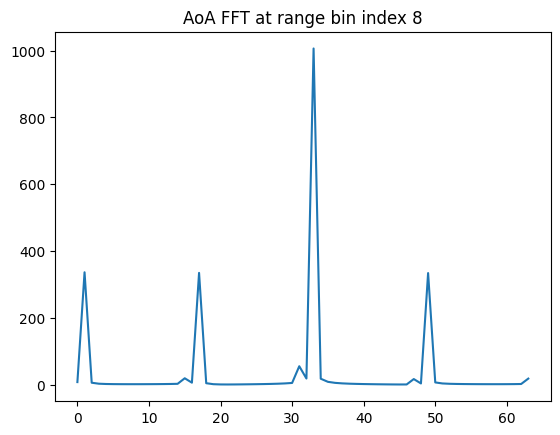

In [23]:
# compute spare array AoA FFT
Sparse1_array = cube.copy()
for rx_idx in range(NR//4):
    Sparse1_array[0,0,0, 4*rx_idx+1, :] = zeros(NA)
    # A_FFT[0,0,0, 4*rx_idx+2, :] = zeros(NA)
    # A_FFT[0,0,0, 4*rx_idx+3, :] = zeros(NA)
R1_fft = fft(Sparse1_array, axis=4)
A1_FFT = fft(R1_fft, axis=3)

# find the range bin index with first target
peak0 = find_peaks(R1_fft[0,0,0,0,:])[0][0]
print(peak0)
plt.title(f"AoA FFT at range bin index {peak0}")
plt.plot(abs(A1_FFT[0,0,0,:,peak0]))

### Example with 2 antennas missing every 4

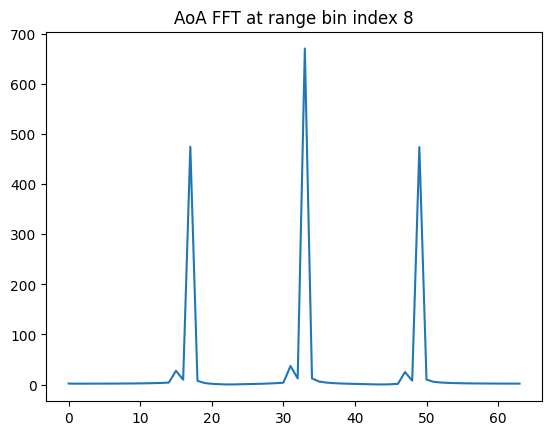

In [24]:
Sparse2_array = cube.copy()
for rx_idx in range(NR//4):
    Sparse2_array[0,0,0, 4*rx_idx+1, :] = zeros(NA)
    Sparse2_array[0,0,0, 4*rx_idx+2, :] = zeros(NA)
    # A_FFT[0,0,0, 4*rx_idx+3, :] = zeros(NA)
R2_fft = fft(Sparse2_array, axis=4)
A2_FFT = fft(R2_fft, axis=3)

plt.title(f"AoA FFT at range bin index {peak0}")
plt.plot(abs(A2_FFT[0,0,0,:,peak0]))

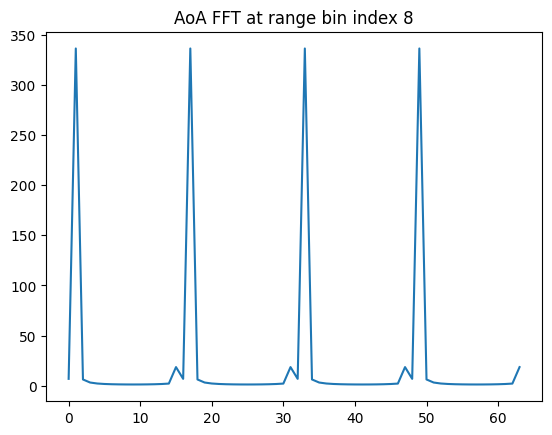

In [25]:
Sparse3_array = cube.copy()
for rx_idx in range(NR//4):
    Sparse3_array[0,0,0, 4*rx_idx+1, :] = zeros(NA)
    Sparse3_array[0,0,0, 4*rx_idx+2, :] = zeros(NA)
    Sparse3_array[0,0,0, 4*rx_idx+3, :] = zeros(NA)
R3_fft = fft(Sparse3_array, axis=4)
A3_FFT = fft(R3_fft, axis=3)

plt.title(f"AoA FFT at range bin index {peak0}")
plt.plot(abs(A3_FFT[0,0,0,:,peak0]))

## Aperture vs sidelobes

Comparing an AoA FFT for 8 antennas either sparse (spacing of 4) or dense

As below shows, the larger aperture - though with the same number of antennas - leads to sharper angular resolution though with larger side lobes (angular uncertainty).

If radar beam pattern can be controlled to ensure no echo at higher angular values, this can be resolved in SW.

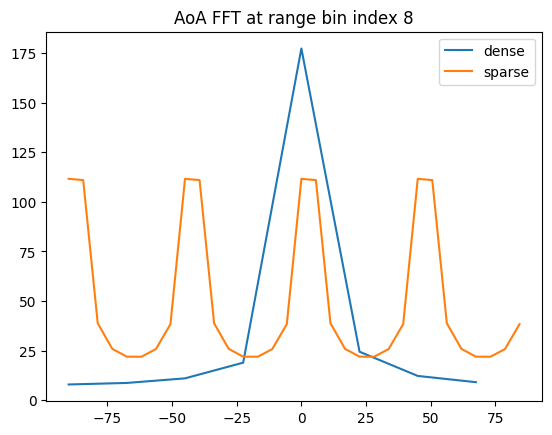

In [26]:
# Number of RX antennas: 8
NR_d = 8
NR_s = 32 # before pruning
RXs_d = [Antenna(x=lambda0/2*i) for i in range(NR_d)]
RXs_s = [Antenna(x=lambda0/2*i) for i in range(NR_s)]
legend = ["dense", "sparse"]
for idx in range(2):
    RXs = [RXs_d, RXs_s][idx]
    radar = Radar(transmitter=Transmitter(bw=3.5e9, slope=_k),
                  receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                    n_adc=NA,
                                    antennas=RXs),
                  debug=False)
    bb = rt_points(radar, targets, debug=False)
    cube = bb["adc_cube"]
    if idx == 1:
        # if sparse then fill RX with zero 
        # equivalent to adding zeros in tensor if reading ADC from radar
        for rx_idx in range(NR_s//4):
            cube[0,0,0, 4*rx_idx+1, :] = zeros(NA)
            cube[0,0,0, 4*rx_idx+2, :] = zeros(NA)
            cube[0,0,0, 4*rx_idx+3, :] = zeros(NA)
    # first compute the range FFT
    R_fft = fft(cube, axis=4)
    # then compute the AoA FFT
    A_FFT = fft(R_fft, axis=3)
    plt.title(f"AoA FFT at range bin index {peak0}")
    # scale x-axis
    angles = arange(-90, 90, 180/len(RXs))
    # plot
    plt.plot(angles, abs(A_FFT[0,0,0,:,peak0]), label=f"{legend[idx]}")
    plt.legend()

### Non regression hook

In [30]:
assert peak0 == 8
print("last successful run on ")
print(datetime.datetime.now())
print("on version", __version__)

last successful run on 
2024-10-01 19:57:22.022264
on version 0.0.7
